In [1]:
using LinearAlgebra
using Plots
using CSV, DataFrames
using LaTeXStrings

In [2]:
function shift_rotate(x, y, θ, x_shift, y_shift, θ_shift)
    v = [x - x_shift, y-y_shift]
    R = [cos(θ_shift) sin(θ_shift); -sin(θ_shift) cos(θ_shift)]
    vf = R*v
    return vf[1], vf[2], (θ - θ_shift)
end

shift_rotate (generic function with 1 method)

In [3]:
# This is the actual data-set
dubinsData = CSV.read("./DataFiles/twoCarsData.csv", DataFrame)

# Add mirrored data so that more data is available
dataMirrored = dubinsData

dataMirrored.yP = -dataMirrored.yP    # y = -y
dataMirrored.thetaP = -dataMirrored.thetaP    # th = -th
dataMirrored.inputP = -dataMirrored.inputP    # u = -u

dataMirrored.yE = -dataMirrored.yE    # y = -y
dataMirrored.thetaE = -dataMirrored.thetaE    # th = -th
dataMirrored.inputE = -dataMirrored.inputE    # u = -u

dubinsData = append!(dubinsData,dataMirrored)

dataP = dubinsData[:, [:xP, :yP, :thetaP, :xE, :yE, :thetaE, :inputP]]
dataE = dubinsData[:, [:xP, :yP, :thetaP, :xE, :yE, :thetaE, :inputE]]
dataP.inputP = Int.(round.(dataP.inputP))
dataE.inputE = Int.(round.(dataE.inputE))

# Transform dataP to pursuer's frame of reference
N = length(dataP.inputP)
for i=1:N
    dataP.xE[i], dataP.yE[i], dataP.thetaE[i] = shift_rotate(dataP.xE[i], dataP.yE[i], dataP.thetaE[i], dataP.xP[i], dataP.yP[i], dataP.thetaP[i])
    dataP.xP[i] = 0
    dataP.yP[i] = 0
    dataP.thetaP[i] = 0
end

# Transform dataE to evader's frame of reference
for i=1:N
    dataE.xP[i], dataE.yP[i], dataE.thetaP[i] = shift_rotate(dataE.xP[i], dataE.yP[i], dataE.thetaP[i], dataE.xE[i], dataE.yE[i], dataE.thetaE[i])
    dataE.xE[i] = 0
    dataE.yE[i] = 0
    dataE.thetaE[i] = 0
end

print(N)

18000

In [4]:
# Remove straight line data-points in dataP
cond1 = (dataP.yE .<= -0.055) .| (dataP.yE .>= 0.055)  # Keep this data which is away from x-axis
cond2 = (collect(1:length(dataP.yE))) .% 1 .== 0  # Keep this data which is index less than 2000
cond3 = (dataP.inputP .!= 0) # Keep the data only if input is nonzero
dataP = dataP[(cond1 .| cond2) .& cond3,:]
select!(dataP, [:xE, :yE, :thetaE ,:inputP])
figDataP = scatter(dataP.xE, dataP.yE, markersize = 1, 
                   color = :blue, msc=:blue, markershape = :circle,
		           legend = false, frame_style = :box)
xlabel!(figDataP, L"$x-\textrm{position}$")
ylabel!(figDataP, L"$y-\textrm{position}$")

# Remove straight line data-points in dataE
cond1 = (dataE.yP .<= -0.055) .| (dataE.yP .>= 0.055)  # Keep this data which is away from x-axi
cond2 = (collect(1:length(dataE.yP))) .% 2000 .== 0  # Keep this data which is index less than 2000
cond3 = (dataE.inputE .!= 0) # Keep the data only if input is nonzero
dataE = dataE[(cond1 .| cond2) .& cond3,:]
select!(dataE, [:xP, :yP, :thetaP ,:inputE])
figDataE = scatter(dataE.xP, dataE.yP, markersize = 1, 
                   color = :blue, msc=:blue, markershape = :circle,
		           legend = false, frame_style = :box)
xlabel!(figDataE, L"$x-\textrm{position}$")
ylabel!(figDataE, L"$y-\textrm{position}$")

# display(figDataP)
# display(figDataE)


# plot!(figDataP, title="Training data in the frame of pursuer")
# savefig(figDataP, "training_data_pursuer.pdf")

# plot!(figDataE, title="Training data in the frame of evader")
# savefig(figDataE, "training_data_evader.pdf")

# print(dataP)

"C:\\Users\\anujp\\Documents\\FinalYear Project\\CS 6001\\notebook vode\\training_data_evader.pdf"

In [5]:
ENV["PYTHON"] = ""          # Use Julia's internal Conda
using Pkg
Pkg.build("PyCall"; verbose=true)

    Building Conda ─→ `C:\Users\anujp\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\8f06b0cfa4c514c7b9546756dbae91fcfbc92dc9\build.log`
    Building PyCall → `C:\Users\anujp\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\9816a3826b0ebf49ab4926e2b18842ad8b5c8f04\build.log`
┌ Info: Using the Python distribution in the Conda package by default.
└ To use a different Python version, set ENV["PYTHON"]="pythoncommand" and re-run Pkg.build("PyCall").
[ Info: Running `conda install -y --satisfied-skip-solve numpy` in root environment

# All requested packages already installed.

[ Info: PyCall is using C:\Users\anujp\.julia\conda\3\x86_64\python.exe (Python 3.12.12) at C:\Users\anujp\.julia\conda\3\x86_64\python.exe, libpython = C:\Users\anujp\.julia\conda\3\x86_64\python312.dll
[ Info: C:\Users\anujp\.julia\packages\PyCall\1gn3u\deps\deps.jl has not changed
[ Info: C:\Users\anujp\.julia\prefs\PyCall has not changed


In [6]:
using Conda
Conda.add("scikit-learn")

[ Info: Running `conda install -y scikit-learn` in root environment


Channels:
 - conda-forge
 - defaults
Platform: win-64
Solving environment: done

# All requested packages already installed.



In [7]:
using ScikitLearn
using ScikitLearn.CrossValidation: train_test_split
@sk_import tree: DecisionTreeClassifier
@sk_import preprocessing: StandardScaler
@sk_import ensemble: RandomForestClassifier
@sk_import tree: export_graphviz
@sk_import metrics: accuracy_score

PyObject <function accuracy_score at 0x00000209EF3739C0>

## Pursuer Training

In [8]:
X_p = [dataP.xE dataP.yE dataP.thetaE]
y_p = dataP.inputP

# Split the data into test-train set
X_train, X_test, y_train, y_test = train_test_split(X_p, y_p, test_size = 0.20)

# naming the classifier Pursuer
Pursuer = RandomForestClassifier(n_estimators = 100)
Pursuer.fit(X_train, y_train)



dot_data = export_graphviz(Pursuer.estimators_[99], 
                           #feature_names=wine.feature_names,
                           #class_names=wine.target_names, 
                           filled=true, impurity=true, 
                           rounded=true)
println(dot_data)

y_pred = Pursuer.predict(X_test)

println("ACCURACY OF THE MODEL: ", accuracy_score(y_test, y_pred))

digraph Tree {
node [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label="x[2] <= 3.143\ngini = 0.482\nsamples = 1653\nvalue = [1058, 1551]", fillcolor="#c0e0f7"] ;
1 [label="x[1] <= -0.036\ngini = 0.359\nsamples = 1276\nvalue = [465, 1522]", fillcolor="#75bbed"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="x[2] <= 1.68\ngini = 0.174\nsamples = 318\nvalue = [460, 49]", fillcolor="#e88e4e"] ;
1 -> 2 ;
3 [label="x[1] <= -1.01\ngini = 0.085\nsamples = 184\nvalue = [281, 13]", fillcolor="#e68742"] ;
2 -> 3 ;
4 [label="x[0] <= -4.749\ngini = 0.009\nsamples = 127\nvalue = [211, 1]", fillcolor="#e5823a"] ;
3 -> 4 ;
5 [label="gini = 0.0\nsamples = 1\nvalue = [0, 1]", fillcolor="#399de5"] ;
4 -> 5 ;
6 [label="gini = 0.0\nsamples = 126\nvalue = [211, 0]", fillcolor="#e58139"] ;
4 -> 6 ;
7 [label="x[0] <= -1.021\ngini = 0.25\nsamples = 57\nvalue = [70, 12]", fillcolor="#e9975b"] ;
3 -> 7 ;
8 [label="gini = 

## Evader Training

In [9]:
X_e = [dataE.xP dataE.yP dataE.thetaP]
y_e = dataE.inputE

# Split the data into test-train set
X_train, X_test, y_train, y_test = train_test_split(X_e, y_e, test_size = 0.20)

# naming the classifier Pursuer
Evader = RandomForestClassifier(n_estimators = 100)
Evader.fit(X_train, y_train)



dot_data = export_graphviz(Evader.estimators_[99], 
                           #feature_names=wine.feature_names,
                           #class_names=wine.target_names, 
                           filled=true, impurity=true, 
                           rounded=true)
# println(dot_data)

y_pred = Evader.predict(X_test)

println("ACCURACY OF THE MODEL: ", accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL: 0.9900299102691924


In [10]:
## Simulation of pursuit-evasion game

Simulation of pursuit-evasion game

In [ ]:
# Simulation using the learned model
dubins_dynP(x, u) = [2.5*cos(x[3]), 2.5*sin(x[3]), 2.5*u]
dubins_dynE(x, u) = [1.0*cos(x[3]), 1.0*sin(x[3]), 1.0*u]


stateP0 = [0, 0, 0]
# stateP0 = [-5.5, -2.1, 2.78]

stateE0 = [-5, 7, π/2]

n_iter = 1500
dt = 0.01

statesP = zeros(n_iter, 3)
inputP = zeros(n_iter)
statesE = zeros(n_iter, 3)
inputE = zeros(n_iter)

statesP[1,:] .= stateP0
statesE[1,:] .= stateE0
last_ind = 1

for i=1:n_iter-1
    sP = statesP[i, :]
    sE = statesE[i, :]

    sET = shift_rotate(sE[1], sE[2], sE[3], sP[1], sP[2], sP[3])
    uP = Pursuer.predict([sET[1] sET[2] sET[3]])[1]
    statesP[i+1,:] .= statesP[i,:] .+ dt*dubins_dynP(statesP[i,:], uP[1])

    sPT = shift_rotate(sP[1], sP[2], sP[3], sE[1], sE[2], sE[3])
    uE = Evader.predict([sPT[1] sPT[2] sPT[3]])[1]
    statesE[i+1,:] .= statesE[i,:] .+ dt*dubins_dynE(statesE[i,:], uE[1])

    inputE[i] = uE

    last_ind = i
    if norm(sP[1:2] - sE[1:2]) < 0.1
        println("Captured!!")
        println(last_ind)
        println(uE)
        break
    end
end



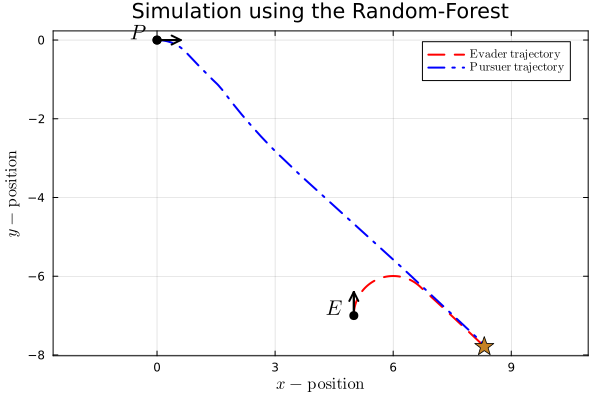

In [14]:

fig1 = plot(aspect_ratio=1, frame_style=:box, lw=2, title = "Simulation using the Random-Forest")
plot!(fig1, statesE[1:last_ind,1], statesE[1:last_ind,2], color=:red, ls=:dash, lw=2, label=L"$\textrm{Evader \; trajectory}$")
plot!(fig1, statesP[1:last_ind,1], statesP[1:last_ind,2], color=:blue, ls=:dashdot, lw=2, label=L"$\textrm{Pursuer \; trajectory}$")
xlabel!(fig1, L"$x-\textrm{position}$")
ylabel!(fig1, L"$y-\textrm{position}$")
x_p0, y_p0 = statesP[1,1], statesP[1,2]
x_e0, y_e0 = statesE[1,1], statesE[1,2]
plot!(fig1, [x_p0, x_p0 + 0.6], [y_p0, y_p0], color=:black, arrow=true, arrowsize=1, lw=2, label=nothing)
scatter!(fig1, [x_p0], [y_p0], color=:black, markersize=5, label=nothing)
plot!(fig1, [x_e0, x_e0 ], [y_e0, y_e0 + 0.6 ], color=:black, arrow=true, arrowsize=1, lw=2, label=nothing)
scatter!(fig1, [x_e0], [y_e0], color=:black, markersize=5, label=nothing)
# plot!(fig1, [0.0, 0.4], [0.0, 0.0], color=:black, arrow=true, arrowsize=1, lw=2, label=nothing)
scatter!(fig1, [0], [0], color=:black, markersize=5, label=nothing)
scatter!(fig1, [statesE[last_ind,1]], [statesE[last_ind,2]], shape=:star5, label=nothing, markersize=10)
annotate!(fig1, x_p0 - 0.5, y_p0 + 0.2, L"$\bf{P}$")
annotate!(fig1, x_e0 - 0.5, y_e0 + 0.2, L"$\bf{E}$")
# x_f = xf[1]
# y_f = xf[2]
# annotate!(fig1, xf[1] + 1.0, xf[2] + 0.3, L"$x_f = [%$x_f, %$y_f]$")
display(fig1)